# Regularized data programming with maximum a posteriori estimation

**Demo of code base on RNA.**

## Preamble

In [1]:
# Importations.
import pandas as pd
import numpy as np
import torch
from bayesian_dp import BayesianDP
from utils import Utils
from train_test import Trainer

## Read data

In [2]:
# Read in labeling function matrix files.
df_train = pd.read_csv("../data/rna/rna_lf_matrix_train.csv")
df_val = pd.read_csv("../data/rna/rna_lf_matrix_val.csv")
df_test = pd.read_csv("../data/rna/rna_lf_matrix_test.csv")

# Explore.
print("\n---------------------------")
print("TRAINING DATA:")
print("---------------------------\n")
print(df_train.info())
display(df_train)

print("---------------------------")
print("VALIDATION DATA:")
print("---------------------------\n")
print(df_val.info())
display(df_val)

print("---------------------------")
print("TEST DATA:")
print("---------------------------\n")
print(df_test.info())
display(df_test)


---------------------------
TRAINING DATA:
---------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656 entries, 0 to 1655
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   0        1656 non-null   int64
 1   1        1656 non-null   int64
 2   2        1656 non-null   int64
 3   Label    1656 non-null   int64
 4   Snorkel  1656 non-null   int64
dtypes: int64(5)
memory usage: 64.8 KB
None


,0,1,2,Label,Snorkel
0,0,0,1,1,1
1,0,0,1,-1,1
2,0,-1,1,-1,-1
3,0,0,1,1,1
4,0,0,-1,-1,-1
...,...,...,...,...,...
1651,0,0,1,1,1
1652,0,-1,1,-1,-1
1653,0,-1,-1,-1,-1
1654,0,-1,-1,-1,-1


---------------------------
VALIDATION DATA:
---------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   0        184 non-null    int64
 1   1        184 non-null    int64
 2   2        184 non-null    int64
 3   Label    184 non-null    int64
 4   Snorkel  184 non-null    int64
dtypes: int64(5)
memory usage: 7.3 KB
None


,0,1,2,Label,Snorkel
0,0,0,-1,-1,-1
1,0,-1,1,-1,-1
2,0,0,1,1,1
3,0,0,1,1,1
4,0,-1,-1,-1,-1
...,...,...,...,...,...
179,0,0,1,1,1
180,0,0,-1,-1,-1
181,0,-1,-1,-1,-1
182,0,-1,1,-1,-1


---------------------------
TEST DATA:
---------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   0        460 non-null    int64
 1   1        460 non-null    int64
 2   2        460 non-null    int64
 3   Label    460 non-null    int64
 4   Snorkel  460 non-null    int64
dtypes: int64(5)
memory usage: 18.1 KB
None


,0,1,2,Label,Snorkel
0,0,0,1,1,1
1,0,0,-1,-1,-1
2,0,0,1,-1,1
3,0,0,1,1,1
4,0,0,1,1,1
...,...,...,...,...,...
455,0,0,1,1,1
456,0,0,-1,-1,-1
457,0,-1,-1,-1,-1
458,0,0,1,1,1


## Process data

In [3]:
# Spam dataset: Disaggregate labeling function outputs and gold labels.
# Drop third and final LF.
L_train = np.array(df_train.drop(columns = ["Label", "Snorkel"]))
y_train = np.array(df_train["Label"])

L_val = np.array(df_val.drop(columns = ["Label", "Snorkel"]))
y_val = np.array(df_val["Label"])

L_test = np.array(df_test.drop(columns = ["Label", "Snorkel"]))
y_test = np.array(df_test["Label"])

print("\n***L_train.shape =", L_train.shape)
display(L_train[:10])
print("\n***L_val.shape =", L_val.shape)
display(L_val[:10])
print("\n***L_test.shape =", L_test.shape)
display(L_test[:10])

display(y_train[:10])
display(y_val[:10])
display(y_test[:10])


***L_train.shape = (1656, 3)


array([[ 0,  0,  1],
       [ 0,  0,  1],
       [ 0, -1,  1],
       [ 0,  0,  1],
       [ 0,  0, -1],
       [ 0,  0,  1],
       [ 0,  0,  1],
       [ 0, -1, -1],
       [ 0,  0,  1],
       [ 0, -1,  1]])


***L_val.shape = (184, 3)


array([[ 0,  0, -1],
       [ 0, -1,  1],
       [ 0,  0,  1],
       [ 0,  0,  1],
       [ 0, -1, -1],
       [ 0,  0,  1],
       [ 0, -1, -1],
       [ 0,  0,  1],
       [-1, -1,  1],
       [ 0, -1,  1]])


***L_test.shape = (460, 3)


array([[ 0,  0,  1],
       [ 0,  0, -1],
       [ 0,  0,  1],
       [ 0,  0,  1],
       [ 0,  0,  1],
       [ 0,  0,  1],
       [ 0,  0, -1],
       [ 0,  0, -1],
       [ 0,  0,  1],
       [ 0, -1,  1]])

array([ 1, -1, -1,  1, -1,  1,  1, -1,  1, -1])

array([-1, -1,  1,  1, -1, -1, -1,  1, -1, -1])

array([ 1, -1, -1,  1,  1,  1, -1, -1,  1, -1])

## Training config

In [4]:
# Total labeling functions.
M = L_train.shape[1]

# Compute empirical betas for training data.
empirical_coverage = []
for i in range(L_train.shape[1]):
    coverage = np.count_nonzero(L_train[:, i]) / L_train.shape[0]
    empirical_coverage.append(coverage)
print("Empirical coverages =\n", empirical_coverage)

# Macros for present experiments.
EPOCHS = 175
LEARNING_RATE = 0.01
TIE_POLICY = "abstain"
INIT_ALPHA = [1.0] * M
INIT_BETA = empirical_coverage
STRENGTH = 10
CLIP_GRADS = 10
OPTIMIZER = torch.optim.SGD
FORCE_ABSTAIN = False

Empirical coverages =
 [0.05253623188405797, 0.3743961352657005, 1.0]


In [5]:
# Instantiate Utils object for utility functions.
utils = Utils()

# Instantiate trainer.
trainer = Trainer()

In [6]:
print("\nTotal LFs =", M)


Total LFs = 3


## Majority vote scores


---------------------------------------------
tn, fp, fn, tp = [142  39   9 165]
F1             = 0.873015873015873
Accuracy       = 0.8647887323943662
Precision      = 0.8088235294117647
Recall         = 0.9482758620689655
ROC AUC        = 0.8664031244046485
Coverage       = 0.7717391304347826
---------------------------------------------



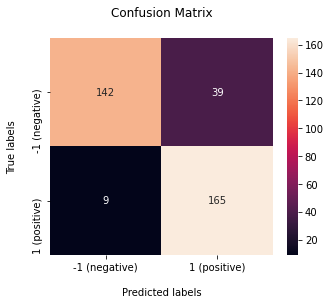

In [7]:
majority_vote = utils.vote_majority(L_test, 
                                    tie_policy = TIE_POLICY)
mv_scores = utils.score(y_test, 
                        majority_vote, 
                        verbose = True, 
                        plot_confusion = True)

## Dummy classifier

In [8]:
# Identify most abundant class.
df_train.Label.value_counts()

-1    1028
 1     628
Name: Label, dtype: int64


---------------------------------------------
tn, fp, fn, tp = [286   0 174   0]
F1             = 0.0
Accuracy       = 0.6217391304347826
Precision      = 0.0
Recall         = 0.0
ROC AUC        = 0.5
Coverage       = 1.0
---------------------------------------------



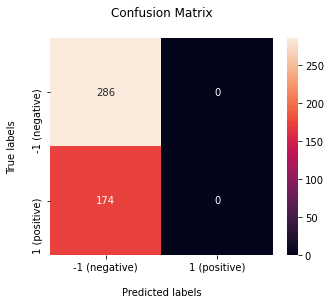

In [9]:
# Dummy classifier: label everything most abundant class.
dummy_scores = utils.score(y_test,
                           np.array([-1] * len(y_test)), 
                           verbose = True, 
                           plot_confusion = True)

## Define priors

### Priors based on empirical accuracy of `L_train`

These are our simulated optimal priors, unrealistically obtained.

In [10]:
# Parameters of best performing model yet.
# Target mean of Beta distribution.

# Known accuracies of each synthetic LF on the training set.
# NOTE: Demote 100% accuracies to 99.9999%, otherwise model cannot learn.
empirical_accuracies = [0.999999, 0.999999, 0.680556]

### Priors based on majority vote over `L_train`

These are our heuristic priors, realistically obtained.

In [11]:
# Get priors from majority vote.
priors_mv = utils.get_priors_majority_vote(L_train, remove_zeros = True)
print("\npriors_mv =\n", priors_mv)
print("\nempirical accuracies =\n", empirical_accuracies)

l2_mv = np.linalg.norm(np.array(priors_mv) - np.array(empirical_accuracies))
print("\nL2 (priors_mv - empirical_accuracies) =", l2_mv)


# Estimated accuracies via majority vote = [0.999999, 0.999999, 0.9879608728367193]

priors_mv =
 [0.999999, 0.999999, 0.9879608728367193]

empirical accuracies =
 [0.999999, 0.999999, 0.680556]

L2 (priors_mv - empirical_accuracies) = 0.30740487283671925


## Untrained MAP model


---------------------------------------------
tn, fp, fn, tp = [142  39   9 165]
F1             = 0.873015873015873
Accuracy       = 0.8647887323943662
Precision      = 0.8088235294117647
Recall         = 0.9482758620689655
ROC AUC        = 0.8664031244046485
Coverage       = 0.7717391304347826
---------------------------------------------



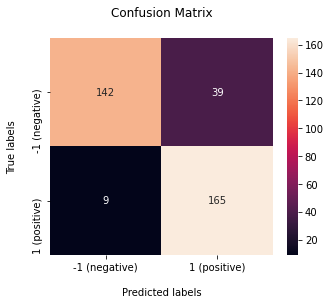

In [12]:
untrained = BayesianDP(INIT_ALPHA,
                       INIT_BETA,
                       priors_alpha = priors_mv)
untrained_pred = untrained.predict(L_test, tie_policy = "abstain")
untrained_scores = utils.score(y_test, 
                               untrained_pred, 
                               verbose = True, 
                               plot_confusion = True)

## Train MAP model

In [13]:
# Instantiate model.
MAP = BayesianDP(alpha = INIT_ALPHA, 
                 beta = INIT_BETA,
                 priors_alpha = priors_mv,
                 prior_strength = STRENGTH)

# Fit model.
scores, losses = MAP.fit(L_train, 
                         L_val = L_val,
                         y_val = y_val,
                         optimizer = OPTIMIZER,
                         learning_rate = LEARNING_RATE,
                         tie_policy = TIE_POLICY,
                         epochs = EPOCHS, 
                         early_stopping = True,
                         patience = 2,
                         clip_grads = CLIP_GRADS,
                         verbose = True)


----------------- INITIAL PARAMETERS -----------------
 
• INIT ALPHA   = tensor([1., 1., 1.]) 
• INIT BETA    = tensor([0.0525, 0.3744, 1.0000]) 
• PRIORS ALPHA = [(1000.0, 0.001000000978820026), (1000.0, 0.001000000978820026), (1000.0, 12.185833930969238)]

----------------- EPOCH 0 -----------------
 
• TRAIN LOSS = 2838.865234375
• VAL   LOSS = 1078.777099609375
• ALPHA      = tensor([0.7427, 0.7426, 0.7414]) 
• BETA       = tensor([0.0525, 0.3744, 1.0000])
• ALPHA GRAD = tensor([-6.0123, -5.9647, -5.3174])

----------------- EPOCH 35 -----------------
 
• TRAIN LOSS = 2293.100830078125
• VAL   LOSS = 465.577880859375
• ALPHA      = tensor([0.9743, 0.9562, 0.8244]) 
• BETA       = tensor([0.0525, 0.3744, 1.0000])
• ALPHA GRAD = tensor([-7.2982, -6.5444,  1.9766])

----------------- EPOCH 70 -----------------
 
• TRAIN LOSS = 2247.415771484375
• VAL   LOSS = 440.8526611328125
• ALPHA      = tensor([0.9969, 0.9945, 0.7872]) 
• BETA       = tensor([0.0525, 0.3744, 1.0000])
• ALPHA GR

## Predict


---------------------------------------------
tn, fp, fn, tp = [247  39   9 165]
F1             = 0.873015873015873
Accuracy       = 0.8956521739130435
Precision      = 0.8088235294117647
Recall         = 0.9482758620689655
ROC AUC        = 0.9059561128526645
Coverage       = 1.0
---------------------------------------------



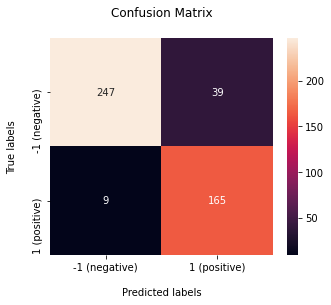

In [16]:
# Predict on test matrix.
y_pred = MAP.predict(L_test, 
                     p_y = 0.5,
                     p_abstain = 0.5,
                     force_abstain = FORCE_ABSTAIN,
                     tie_policy = "abstain", 
                     return_proba = False)

# Score test set predictions.
test_scores = utils.score(y_test,
                          y_pred,
                          verbose = True, 
                          plot_confusion = True)

## Train-test pipeline


----------------- INITIAL PARAMETERS -----------------
 
• INIT ALPHA   = tensor([1., 1., 1.]) 
• INIT BETA    = tensor([0.0525, 0.3744, 1.0000]) 
• PRIORS ALPHA = [(1000.0, 0.001000000978820026), (1000.0, 0.001000000978820026), (1000.0, 12.185833930969238)]

----------------- EPOCH 0 -----------------
 
• TRAIN LOSS = 2838.865234375
• VAL   LOSS = 1078.777099609375
• ALPHA      = tensor([0.7427, 0.7426, 0.7414]) 
• BETA       = tensor([0.0525, 0.3744, 1.0000])
• ALPHA GRAD = tensor([-6.0123, -5.9647, -5.3174])

----------------- EPOCH 35 -----------------
 
• TRAIN LOSS = 2293.100830078125
• VAL   LOSS = 465.577880859375
• ALPHA      = tensor([0.9743, 0.9562, 0.8244]) 
• BETA       = tensor([0.0525, 0.3744, 1.0000])
• ALPHA GRAD = tensor([-7.2982, -6.5444,  1.9766])

----------------- EPOCH 70 -----------------
 
• TRAIN LOSS = 2247.415771484375
• VAL   LOSS = 440.8526611328125
• ALPHA      = tensor([0.9969, 0.9945, 0.7872]) 
• BETA       = tensor([0.0525, 0.3744, 1.0000])
• ALPHA GR

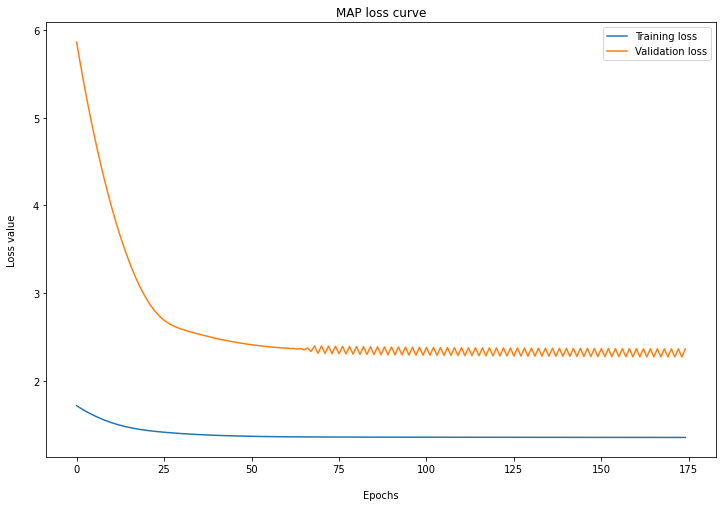


• MAP ALPHA  = tensor([0.9994, 0.9990, 0.7836]) 
• MAP BETA   = tensor([0.0525, 0.3744, 1.0000])

--- L2 norms: ---

L2 norm of (priors_alpha - final_alpha): 0.204


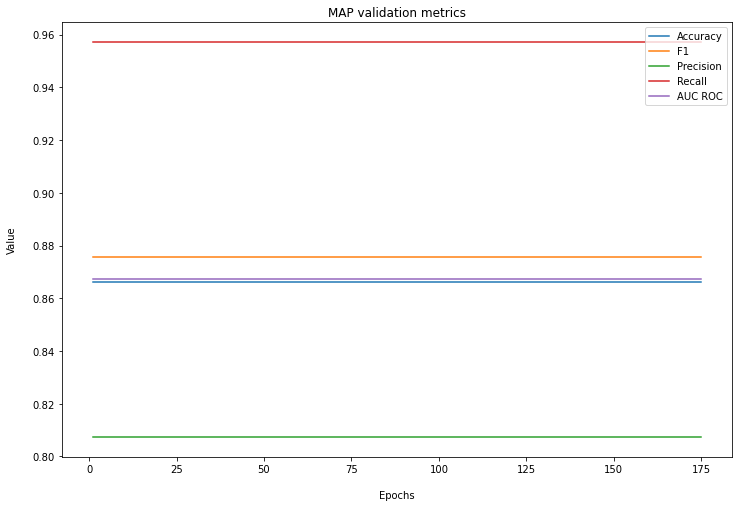


--- FINAL TEST SCORES ---


---------------------------------------------
tn, fp, fn, tp = [247  39   9 165]
F1             = 0.873015873015873
Accuracy       = 0.8956521739130435
Precision      = 0.8088235294117647
Recall         = 0.9482758620689655
ROC AUC        = 0.9059561128526645
Coverage       = 1.0
---------------------------------------------



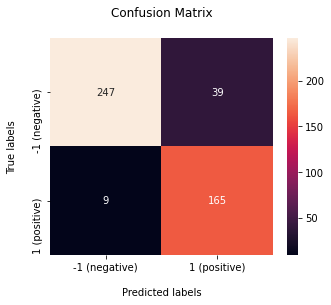

[0.8956521739130435,
 0.873015873015873,
 0.8088235294117647,
 0.9482758620689655,
 0.9059561128526645,
 1.0]

In [15]:
trainer.train_test_score(L_train,
                         L_val,
                         L_test, 
                         y_val,
                         y_test,
                         INIT_ALPHA,
                         INIT_BETA,
                         OPTIMIZER,
                         priors_mv,
                         tie_policy = "abstain",
                         prior_strength = STRENGTH,
                         force_abstain = FORCE_ABSTAIN,
                         epochs = EPOCHS,
                         learning_rate = LEARNING_RATE,
                         early_stopping = True,
                         patience = 2,
                         clip_grads = 10,
                         verbose = True)